In [1]:
import os
import torch
import numpy as np

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 52013142,      # Your seed number, you can pick your lucky number. :)
    'test_ratio': 0.3,
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 300,     # Number of epochs.            
    'batch_size': 5, 
    'learning_rate': 1e-5,              
    'early_stop': 10,    # If model has not improved for this many consecutive epochs, stop training.     
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\'
}

# Some Utility Functions

In [3]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
def random_spatial_sequence(split_rate, full_sequence):
    counts = len(full_sequence)
    len1 = int(counts * split_rate)
    len2 = counts - len1
    index1 = np.random.choice(full_sequence, len1, replace=False)
    index2 = np.setdiff1d(full_sequence, index1)
    print('**************************Data Spliting***************************')
    print('Spliting Rate: ', split_rate)
    print(len1, 'of Dataset1: ',index1)
    print(len2, 'of Dataset2: ',index2)
    print('**************************Data Spliting***************************')
    return index1, index2

def collate_fn(batch):
#     print(batch)
#     print(len(batch[0]))
    # 从每个样本的字典中获取处理结果、标签和其他数据，并将它们存储在同一个字典中
    processed_data = [torch.FloatTensor(sample["processed_data"]) for sample in batch]
    label_data = [sample["label_data"] for sample in batch]
    
    # 将所有需要传递的数据都保存在同一个字典中
    batch_dict = {"processed_data": torch.stack(processed_data),
                  "label_data": label_data}
    
    return batch_dict

In [4]:
class SMAPDataset(Dataset):
    '''
    root: root of input data
    temperal_sequence: the sequence of valid day
    spatial_sequence: the sequence of valid SMAPID
    test: the flag to identify if it is the test dataset
    '''
    def __init__(self, root, temperal_sequence, spatial_sequence):
        # variables for input
        self.smap = []
        self.texture = []
        
        # variables for output
        self.sm = []
        self.smap_unorm = []
        self.ati = [] # contains [ati, atim, atisd] in each element
        
        print('***************************Load data path******************************')
        for i in temperal_sequence: # for example: 20151015
            print('_______________________________' + str(i) + '_______________________________')
            for j in spatial_sequence: # for example: 1
                print('_____________________________smap cell: ' + str(j) + '_____________________________')
                # add path for input variables
                self.smap.append(root + 'INPUT\\SMAP\\' + i + '\\' + str(j) + '.npy')
                self.texture.append(root + 'INPUT\\TEXTURE\\' + str(j) + '.npy')
                # display adding path
                print((root + 'INPUT\\SMAP\\' + i + '\\' + str(j) + '.npy'))
                print((root + 'INPUT\\TEXTURE\\' + str(j) + '.npy'))
                print(os.path.exists(root + 'INPUT\\SMAP\\' + i + '\\' + str(j) + '.npy'))
                print(os.path.exists(root + 'INPUT\\TEXTURE\\' + str(j) + '.npy'))
                      
                # one smap to many in-situ sm
                self.smap_unorm.append(root + 'LABEL\\SMAP\\' + i + '\\' + str(j) + '.npy')
                smap_to_insitu = np.load(root + "LABEL\\SMAPID2INSITUID\\" + str(j) + '.npy')
                insitu_sm_list = []
                insitu_ati_list = []
                for _id in smap_to_insitu:
                    insitu_sm_list.append(root + "LABEL\\SM\\" + i + "\\" + str(_id) + ".npy")
                    insitu_ati_list.append(root + "LABEL\\ATI\\" + i + "\\" + str(_id) + ".npy")
                    # display adding path
                    print((root + "LABEL\\SM\\" + i + "\\" + str(_id) + ".npy"))
                    print((root + "LABEL\\ATI\\" + i + "\\" + str(_id) + ".npy"))
                    print(os.path.exists(root + "LABEL\\SM\\" + i + "\\" + str(_id) + ".npy"))
                    print(os.path.exists(root + "LABEL\\ATI\\" + i + "\\" + str(_id) + ".npy"))
                      
                # add the data of insitu in insitu_list
                self.sm.append(insitu_sm_list)
                self.ati.append(insitu_ati_list)    
                      
    def __getitem__(self, idx):
        smap_path = self.smap[idx]
        smap_unorm_path = self.smap_unorm[idx]
        texture_path = self.texture[idx]
        smap = np.load(smap_path)
        smap_unorm = np.load(smap_unorm_path)
        texture = np.load(texture_path)
        
        data_pkg = {'processed_data': [], 'label_data': []}
        
        # choose flatten as the way to concatenate the input feature
        x = self.__flatten__(smap, texture)
        data_pkg['processed_data'] = x
        
        sm_list = self.sm[idx]
        ati_list = self.ati[idx]
        y = [] # y -> [[sm, smap, ati], ...], sm -> [float], smap -> [float],1 ati -> [ati, atim, atisd]
        for i in range(len(sm_list)):
            sm_path = sm_list[i]
            ati_path = ati_list[i]
            sm = np.load(sm_path, allow_pickle=True)
            ati = np.load(ati_path, allow_pickle=True)
            data_pkg['label_data'].append([sm, smap_unorm, ati])      # label_data -> [[sm, smap, ati], ...], 
                                                                    # sm -> [float]
                                                                    # smap -> [float], 
                                                                    # ati -> [ati, atim, atisd]
            
            # test: each element in list of batch should be of equal size
#             break
        return data_pkg

    def __len__(self):
        return len(self.smap)

    ### the way to concatenate input data
    def __flatten__(self, smap, texture):
        # normalization is done before loading
        texture_flat = texture.flatten()
        return  np.concatenate((smap, texture_flat), axis=0)
    
    def get_input_shape(self, idx):
        data_pkg = self.__getitem__(0)
        return data_pkg['processed_data'].shape

In [12]:
# Set seed for reproducibility
same_seed(config['seed'])

# Get the id sequence of all valid SMAP
directory = config['root'] + 'LABEL\\SMAPID2INSITUID\\'
full_spatial_sequence_smap = sorted([int(f.split('.')[0]) for f in os.listdir(directory) if f.endswith('.npy')]) # !!!! read out of order
print(len(full_spatial_sequence_smap), 'of Full Spatial Sequence: ', full_spatial_sequence_smap)

# Split the train\valid\test dataset by spatial dimension
train_spatial_seq, test_spatial_seq = random_spatial_sequence(1-config['test_ratio'], full_spatial_sequence_smap)
train_spatial_seq, valid_spatial_seq = random_spatial_sequence(1-config['valid_ratio'], train_spatial_seq)

# Initialize the dataset
temperal_seq = ['20151015']
train_dataset = SMAPDataset(config['root'], temperal_seq, train_spatial_seq)
valid_dataset = SMAPDataset(config['root'], temperal_seq, valid_spatial_seq)
test_dataset = SMAPDataset(config['root'], temperal_seq, test_spatial_seq)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True, collate_fn=collate_fn)

21 of Full Spatial Sequence:  [2, 8, 9, 10, 15, 16, 17, 18, 20, 26, 27, 29, 31, 32, 33, 40, 41, 43, 44, 45, 51]
**************************Data Spliting***************************
Spliting Rate:  0.7
14 of Dataset1:  [18 29 26 40 15 32 17  9 33 27 16 44 10 31]
7 of Dataset2:  [ 2  8 20 41 43 45 51]
**************************Data Spliting***************************
**************************Data Spliting***************************
Spliting Rate:  0.8
11 of Dataset1:  [15 40 44 17 32 27 33 26 16 29 18]
3 of Dataset2:  [ 9 10 31]
**************************Data Spliting***************************
***************************Load data path******************************
_______________________________20151015_______________________________
_____________________________smap cell: 15_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\SMAP\20151015\15.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\INPUT\TEXTURE

# Data Visualization by Dataloader

In [11]:
print(next(iter(train_loader)))

{'processed_data': tensor([[-0.2203, -0.6194,  0.6642,  ..., -0.7906, -0.7906, -0.7863],
        [ 0.2028, -0.5415,  0.7344,  ..., -0.8055, -0.7615, -0.8011],
        [ 1.0593,  0.3429,  1.3725,  ..., -0.7803, -0.7803, -0.7756],
        [-0.1949,  0.2116,  1.1317,  ..., -0.7922, -0.7086, -0.7880],
        [-0.0290, -0.6344,  0.6306,  ..., -0.8030, -0.7609, -0.7988]]), 'label_data': [[[array([0.18296875]), array([0.18557811], dtype=float32), array([0.037972831, 0.037595313, 0.006869177], dtype=object)]], [[array([0.31352448]), array([0.19732055], dtype=float32), array([0.030971155, 0.028718248, 0.004598189], dtype=object)]], [[array([0.44663889]), array([0.22108494], dtype=float32), array([0.035326588, 0.038871285, 0.003417908], dtype=object)], [array([0.1965]), array([0.22108494], dtype=float32), array([0.042131071, 0.038871285, 0.003417908], dtype=object)]], [[array([0.28088889]), array([0.18628415], dtype=float32), array([0.045622635999999994, 0.03129749, 0.004641716], dtype=object)]

11


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[array([0.18296875]), array([0.04655674]), array([0.36024028]), array([0.28088889]), array([0.1661815]), array([0.41953237]), array([0.10252962]), array([0.44663889]), array([0.]), array([0.31352448]), array([0.26802439])]


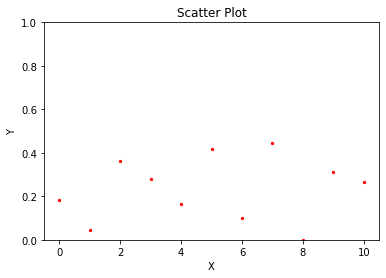